In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# === Load CSV files ===
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')

# === Merge by 'name' ===
merged_df = pd.merge(feat_df, prop_df, on='name')

# === Define flattened connectivity columns ===
element_cols = [f'element_{i}' for i in range(1, 26)]

# === Corrected geometry feature computation ===
def compute_geometry_features(row):
    # 1) Extract node coordinates
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    num_nodes = len(nodes)

    # 2) Reconstruct edges from flattened 5x5 connectivity
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u = k // 5
            v = k % 5
            if u < v < num_nodes:
                x1, y1 = nodes[u]
                x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1 - x2, y1 - y2))

    num_edges = len(edge_lengths)
    avg_edge_length = np.mean(edge_lengths) if edge_lengths else 0.0
    std_edge_length = np.std(edge_lengths)  if edge_lengths else 0.0

    return pd.Series({
        'num_nodes'       : num_nodes,
        'num_edges'       : num_edges,
        'avg_edge_length' : avg_edge_length,
        'std_edge_length' : std_edge_length
    })

# === Apply and concatenate geometry features ===
geometry_df = merged_df.apply(compute_geometry_features, axis=1)
merged_df = pd.concat([merged_df, geometry_df], axis=1)

# === Select inputs and target ===
input_cols = element_cols + ['num_nodes', 'num_edges', 'avg_edge_length', 'std_edge_length']
target_col = 'Isotropy'

# === Drop missing ===
merged_df = merged_df.dropna(subset=input_cols + [target_col])

# === Log-transform target ===
merged_df['log_isotropy'] = np.log1p(merged_df[target_col])

# === Extract X and y ===
X = merged_df[input_cols].values
y = merged_df['log_isotropy'].values.reshape(-1, 1)

# === Train-test split and scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

# === Create PyTorch DataLoader ===
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ Data preprocessing complete.")
print(f"Training samples: {len(train_dataset)}, Feature dimension: {X_train.shape[1]}")


✅ Data preprocessing complete.
Training samples: 145335, Feature dimension: 29


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Instantiate model
input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {total_loss / len(train_loader):.4f}")


Epoch  10 | Loss: 0.7223
Epoch  20 | Loss: 0.7084
Epoch  30 | Loss: 0.6980
Epoch  40 | Loss: 0.6942
Epoch  50 | Loss: 0.6889
Epoch  60 | Loss: 0.6881
Epoch  70 | Loss: 0.6846
Epoch  80 | Loss: 0.6815
Epoch  90 | Loss: 0.6818
Epoch 100 | Loss: 0.6805


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy()
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_real = np.expm1(y_pred_log)  # Inverse of log1p

    y_test_log = scaler_y.inverse_transform(y_test_scaled)
    y_test_real = np.expm1(y_test_log)

# Metrics
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)
print(f"\nTest MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")



Test MAE: 5325.5578
Test R² Score: 0.0595


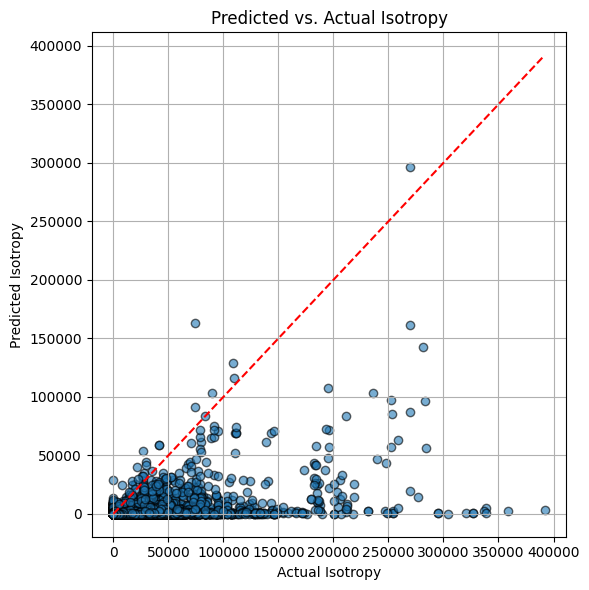

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.6, edgecolors='k')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Actual Isotropy')
plt.ylabel('Predicted Isotropy')
plt.title('Predicted vs. Actual Isotropy')
plt.grid(True)
plt.tight_layout()
plt.show()


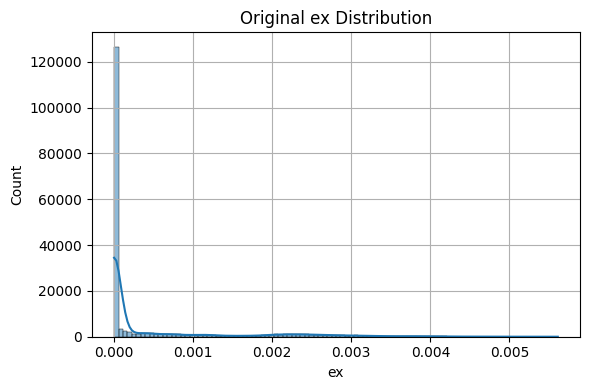

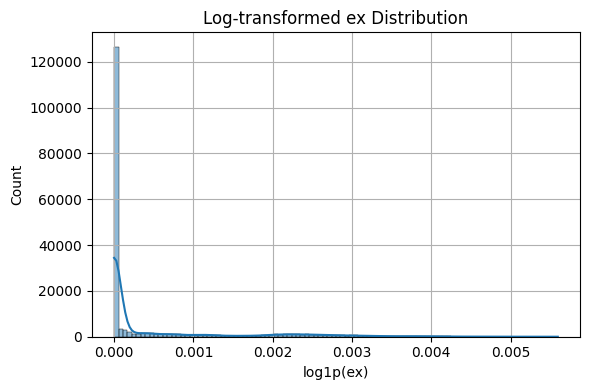

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot original ex distribution
plt.figure(figsize=(6,4))
sns.histplot(df['ex'], bins=100, kde=True)
plt.title("Original ex Distribution")
plt.xlabel("ex")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot log-transformed ex
plt.figure(figsize=(6,4))
sns.histplot(df['log_ex'], bins=100, kde=True)
plt.title("Log-transformed ex Distribution")
plt.xlabel("log1p(ex)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Output sample of predicted and true values
for i in range(10):
    print(f"Sample {i}: Predicted={y_pred_real[i][0]:.2f}, Actual={y_test_real[i][0]:.2f}")


Sample 0: Predicted=375.47, Actual=0.51
Sample 1: Predicted=58.95, Actual=0.37
Sample 2: Predicted=111.28, Actual=8.02
Sample 3: Predicted=371.94, Actual=1.62
Sample 4: Predicted=4.85, Actual=8.14
Sample 5: Predicted=100.01, Actual=21.41
Sample 6: Predicted=72.66, Actual=6.27
Sample 7: Predicted=157.95, Actual=214.22
Sample 8: Predicted=4.41, Actual=29.86
Sample 9: Predicted=75.69, Actual=0.09


In [ ]:
print(f"Epoch {epoch+1:3d} | Loss: {total_loss / len(train_loader):.6f}")


Epoch 100 | Loss: 0.825836


In [ ]:
pip install xgboost -q

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:

element_features = [f'element_{i}' for i in range(1, 26)]
geo_features = ['num_nodes', 'num_edges', 'avg_edge_length', 'std_edge_length']
input_cols = element_features + geo_features

target_col = 'ex'  # x-direction Young's modulus
df = df.dropna(subset=input_cols + [target_col])

# Optional: log-transform target
use_log_transform = True
if use_log_transform:
    df['target'] = np.log1p(df[target_col])
else:
    df['target'] = df[target_col]

# Prepare X and y
X = df[input_cols]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)

# Inverse log1p if needed
if use_log_transform:
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)
else:
    y_pred_real = y_pred
    y_test_real = y_test

mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"\n✅ XGBoost Test MAE: {mae:.6f}")
print(f"✅ XGBoost Test R² Score: {r2:.4f}")



✅ XGBoost Test MAE: 0.000614
✅ XGBoost Test R² Score: 0.0922


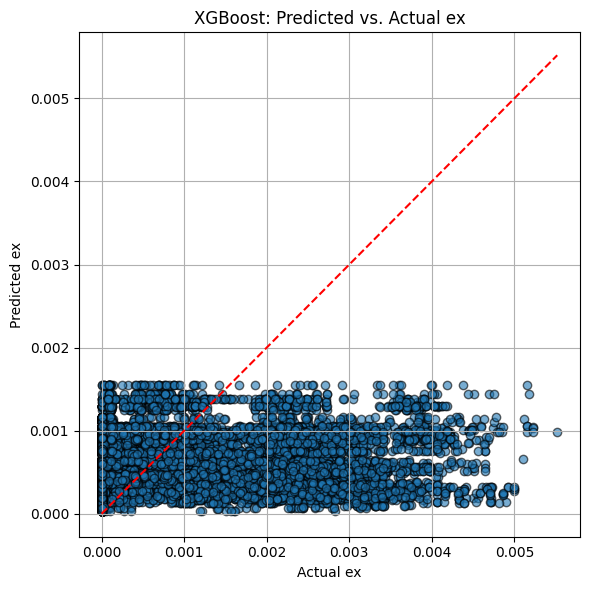

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.6, edgecolors='k')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Actual ex')
plt.ylabel('Predicted ex')
plt.title('XGBoost: Predicted vs. Actual ex')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip uninstall xgboost -y
!pip install xgboost>=1.7 -q

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4


[0]	eval-rmse:3.53215
[50]	eval-rmse:3.11754
[100]	eval-rmse:3.04292
[150]	eval-rmse:3.00310
[200]	eval-rmse:2.97370
[250]	eval-rmse:2.94525
[300]	eval-rmse:2.91772
[350]	eval-rmse:2.89414
[400]	eval-rmse:2.87358
[450]	eval-rmse:2.85319
[500]	eval-rmse:2.83715
[550]	eval-rmse:2.82206
[600]	eval-rmse:2.80799
[650]	eval-rmse:2.79493
[700]	eval-rmse:2.78180
[750]	eval-rmse:2.77118
[800]	eval-rmse:2.75796
[850]	eval-rmse:2.74469
[900]	eval-rmse:2.73401
[950]	eval-rmse:2.72207
[999]	eval-rmse:2.71229
Test MAE (Isotropy): 5249.10
Test R²      (Isotropy): 0.0235


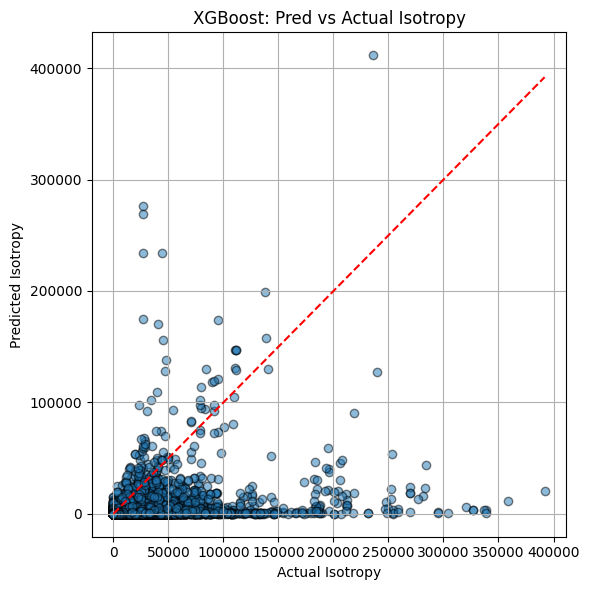

<Figure size 800x600 with 0 Axes>

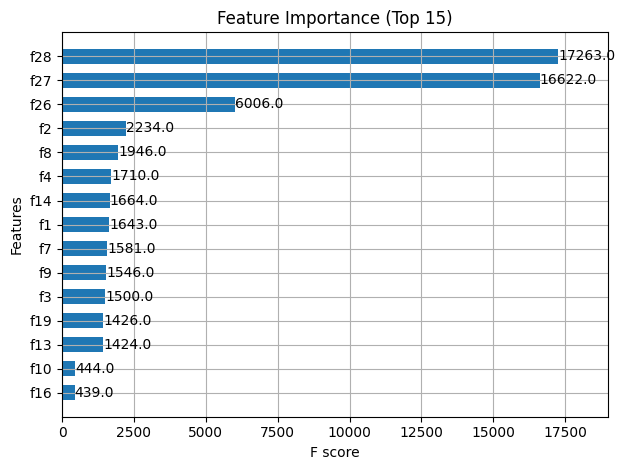

In [ ]:


import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Load and merge data
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 3. Compute geometry features
element_cols = [f'element_{i}' for i in range(1, 26)]

def compute_geometry_features(row):
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(nodes):
                x1, y1 = nodes[u]
                x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1 - x2, y1 - y2))
    return pd.Series({
        'num_nodes'       : len(nodes),
        'num_edges'       : len(edge_lengths),
        'avg_edge_length' : np.mean(edge_lengths) if edge_lengths else 0.0,
        'std_edge_length' : np.std(edge_lengths)  if edge_lengths else 0.0
    })

geom_df = df.apply(compute_geometry_features, axis=1)
df = pd.concat([df, geom_df], axis=1)

# 4. Prepare features and target
input_cols = element_cols + ['num_nodes','num_edges','avg_edge_length','std_edge_length']
df = df.dropna(subset=input_cols + ['Isotropy']).copy()
df['log_iso'] = np.log1p(df['Isotropy'])

X = df[input_cols].values
y = df['log_iso'].values

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Build DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# 7. Set parameters
params = {
    'objective'         : 'reg:squarederror',
    'learning_rate'     : 0.05,
    'max_depth'         : 6,
    'subsample'         : 0.8,
    'colsample_bytree'  : 0.8,
    'eval_metric'       : 'rmse',
    'seed'              : 42
}

# 8. Train with early stopping
evals = [(dtest, 'eval')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# 9. Predict & inverse-transform
y_pred_log = bst.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# 10. Evaluate
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"Test MAE (Isotropy): {mae:.2f}")
print(f"Test R²      (Isotropy): {r2:.4f}")

# 11. Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()],'r--')
plt.xlabel('Actual Isotropy')
plt.ylabel('Predicted Isotropy')
plt.title('XGBoost: Pred vs Actual Isotropy')
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. Feature importance
plt.figure(figsize=(8,6))
xgb.plot_importance(bst, max_num_features=15, height=0.6)
plt.title("Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Load and merge data
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2. Compute geometry features
element_cols = [f'element_{i}' for i in range(1, 26)]

def compute_geometry_features(row):
    # extract node coordinates
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    # reconstruct edges from flattened 5x5 connectivity
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(nodes):
                x1, y1 = nodes[u]
                x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1 - x2, y1 - y2))
    return pd.Series({
        'num_nodes'       : len(nodes),
        'num_edges'       : len(edge_lengths),
        'avg_edge_length' : np.mean(edge_lengths) if edge_lengths else 0.0,
        'std_edge_length' : np.std(edge_lengths)  if edge_lengths else 0.0
    })

geom_df = df.apply(compute_geometry_features, axis=1)
df = pd.concat([df, geom_df], axis=1)

# 3. Prepare inputs and target
input_cols = element_cols + ['num_nodes', 'num_edges', 'avg_edge_length', 'std_edge_length']
df = df.dropna(subset=input_cols + ['Isotropy']).copy()
df['log_iso'] = np.log1p(df['Isotropy'])

X = df[input_cols].values
y = df['log_iso'].values

# 4. Train/validation/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# 5. Reshape targets to 2D
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# 6. Scale inputs and targets
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# 7. Create PyTorch DataLoaders
train_ds = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 8. Define improved MLP
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 9. Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

best_val_loss = float('inf')
patience, counter = 20, 0

# 10. Training loop with early stopping
for epoch in range(1, 201):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mlp.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 11. Evaluate on test set
model.load_state_dict(torch.load('best_mlp.pth'))
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nTest MAE (Isotropy): {mae:.4f}, R²: {r2:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train Loss: 0.8619 | Val Loss: 0.8011
Epoch 002 | Train Loss: 0.8235 | Val Loss: 0.7833
Epoch 003 | Train Loss: 0.8072 | Val Loss: 0.7681
Epoch 004 | Train Loss: 0.7957 | Val Loss: 0.7611
Epoch 005 | Train Loss: 0.7830 | Val Loss: 0.7427
Epoch 006 | Train Loss: 0.7766 | Val Loss: 0.7346
Epoch 007 | Train Loss: 0.7686 | Val Loss: 0.7306
Epoch 008 | Train Loss: 0.7653 | Val Loss: 0.7258
Epoch 009 | Train Loss: 0.7597 | Val Loss: 0.7198
Epoch 010 | Train Loss: 0.7555 | Val Loss: 0.7210
Epoch 011 | Train Loss: 0.7531 | Val Loss: 0.7162
Epoch 012 | Train Loss: 0.7498 | Val Loss: 0.7117
Epoch 013 | Train Loss: 0.7456 | Val Loss: 0.7071
Epoch 014 | Train Loss: 0.7447 | Val Loss: 0.7057
Epoch 015 | Train Loss: 0.7432 | Val Loss: 0.7088
Epoch 016 | Train Loss: 0.7426 | Val Loss: 0.7062
Epoch 017 | Train Loss: 0.7400 | Val Loss: 0.7044
Epoch 018 | Train Loss: 0.7373 | Val Loss: 0.6986
Epoch 019 | Train Loss: 0.7348 | Val Loss: 0.7010
Epoch 020 | Train Loss: 0.7344 | Val Loss: 0.6958


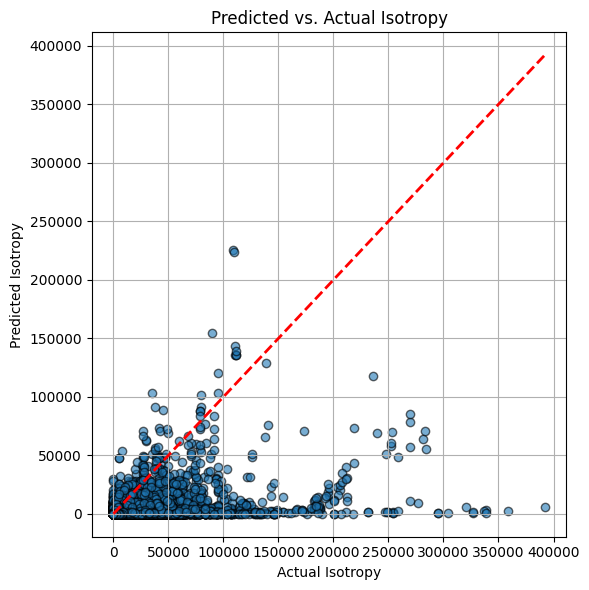

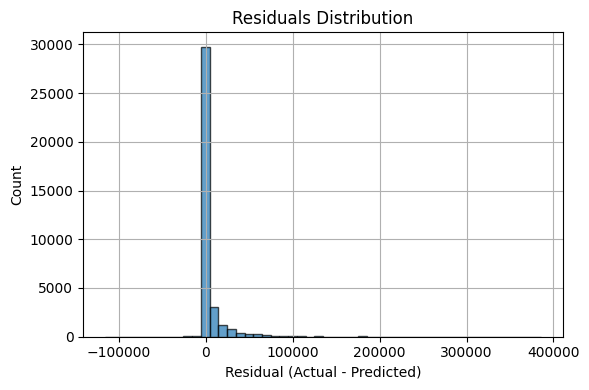

In [ ]:
import matplotlib.pyplot as plt

# 1. Scatter: Predicted vs. Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Isotropy')
plt.ylabel('Predicted Isotropy')
plt.title('Predicted vs. Actual Isotropy')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residuals Histogram
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# === Load and merge data ===
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# === Compute geometry features ===
element_cols = [f'element_{i}' for i in range(1, 26)]

def compute_geometry_features(row):
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(nodes):
                x1, y1 = nodes[u]
                x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1 - x2, y1 - y2))
    return pd.Series({
        'num_nodes': len(nodes),
        'num_edges': len(edge_lengths),
        'avg_edge_length': np.mean(edge_lengths) if edge_lengths else 0.0,
        'std_edge_length': np.std(edge_lengths)  if edge_lengths else 0.0
    })

geom_df = df.apply(compute_geometry_features, axis=1)
df = pd.concat([df, geom_df], axis=1)

# === Compute graph-theoretic features ===
def compute_graph_features(row):
    # build graph from nodes and edges
    coords = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            coords.append((x, y))
    G = nx.Graph()
    G.add_nodes_from(range(len(coords)))
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(coords):
                G.add_edge(u, v)
    degrees = [deg for _, deg in G.degree()]
    return pd.Series({
        'avg_degree': np.mean(degrees)       if degrees else 0.0,
        'max_degree': np.max(degrees)        if degrees else 0.0,
        'num_components': nx.number_connected_components(G),
        'avg_clustering': nx.average_clustering(G) if len(G) > 0 else 0.0
    })

graph_df = df.apply(compute_graph_features, axis=1)
df = pd.concat([df, graph_df], axis=1)

# === Prepare inputs and target ===
input_cols = (
    element_cols +
    ['num_nodes', 'num_edges', 'avg_edge_length', 'std_edge_length'] +
    ['avg_degree', 'max_degree', 'num_components', 'avg_clustering']
)
df = df.dropna(subset=input_cols + ['Isotropy']).copy()
df['log_iso'] = np.log1p(df['Isotropy'])

X = df[input_cols].values
y = df['log_iso'].values.reshape(-1, 1)

# === Split and scale ===
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# === Create DataLoaders ===
train_ds = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
val_ds   = TensorDataset(
    torch.tensor(X_val_scaled,   dtype=torch.float32),
    torch.tensor(y_val_scaled,   dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

print("Data preprocessing complete. Feature dimension:", X_train.shape[1])


Data preprocessing complete. Feature dimension: 33


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train Loss: 0.3974 | Val Loss: 0.3664
Epoch 002 | Train Loss: 0.3764 | Val Loss: 0.3578
Epoch 003 | Train Loss: 0.3689 | Val Loss: 0.3493
Epoch 004 | Train Loss: 0.3629 | Val Loss: 0.3440
Epoch 005 | Train Loss: 0.3579 | Val Loss: 0.3367
Epoch 006 | Train Loss: 0.3542 | Val Loss: 0.3328
Epoch 007 | Train Loss: 0.3490 | Val Loss: 0.3289
Epoch 008 | Train Loss: 0.3474 | Val Loss: 0.3290
Epoch 009 | Train Loss: 0.3456 | Val Loss: 0.3250
Epoch 010 | Train Loss: 0.3440 | Val Loss: 0.3251
Epoch 011 | Train Loss: 0.3427 | Val Loss: 0.3241
Epoch 012 | Train Loss: 0.3415 | Val Loss: 0.3220
Epoch 013 | Train Loss: 0.3400 | Val Loss: 0.3206
Epoch 014 | Train Loss: 0.3384 | Val Loss: 0.3181
Epoch 015 | Train Loss: 0.3378 | Val Loss: 0.3183
Epoch 016 | Train Loss: 0.3370 | Val Loss: 0.3182
Epoch 017 | Train Loss: 0.3357 | Val Loss: 0.3174
Epoch 018 | Train Loss: 0.3351 | Val Loss: 0.3154
Epoch 019 | Train Loss: 0.3342 | Val Loss: 0.3161
Epoch 020 | Train Loss: 0.3332 | Val Loss: 0.3162


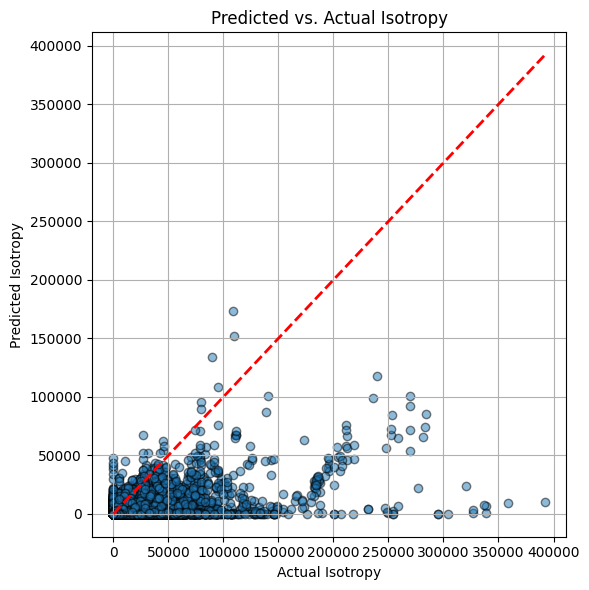

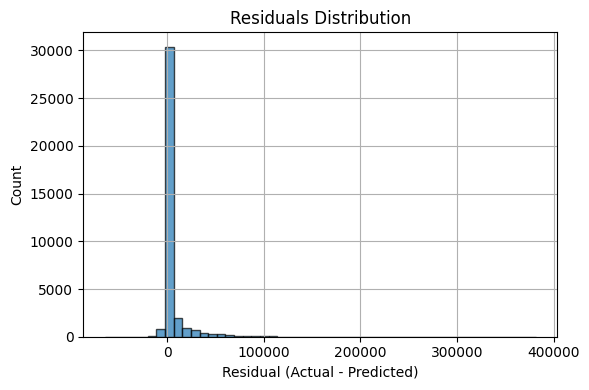

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Load and merge data
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2. Compute geometry features
element_cols = [f'element_{i}' for i in range(1, 26)]

def compute_geometry_features(row):
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(nodes):
                x1, y1 = nodes[u]
                x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1 - x2, y1 - y2))
    return pd.Series({
        'num_nodes': len(nodes),
        'num_edges': len(edge_lengths),
        'avg_edge_length': np.mean(edge_lengths) if edge_lengths else 0.0,
        'std_edge_length': np.std(edge_lengths)  if edge_lengths else 0.0
    })

geom_df = df.apply(compute_geometry_features, axis=1)
df = pd.concat([df, geom_df], axis=1)

# 3. Prepare inputs and target
input_cols = element_cols + ['num_nodes','num_edges','avg_edge_length','std_edge_length']
df = df.dropna(subset=input_cols + ['Isotropy']).copy()
df['log_iso'] = np.log1p(df['Isotropy'])

X = df[input_cols].values
y = df['log_iso'].values.reshape(-1,1)

# 4. Split into train/val/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# 5. Scale features and targets
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# 6. Create DataLoaders
train_ds = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 7. Define improved MLP
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 8. Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(X_train.shape[1]).to(device)
criterion = nn.SmoothL1Loss()  # Huber loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

best_val_loss = float('inf')
patience, counter = 20, 0

# 9. Training loop with early stopping
for epoch in range(1, 201):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mlp.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 10. Load best model & evaluate on test set
model.load_state_dict(torch.load('best_mlp.pth', map_location=device))
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

# Inverse transforms
y_pred_log = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_log = y_test.flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_true_log)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nTest MAE: {mae:.2f}, R²: {r2:.4f}")

# 11. Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
plt.xlabel('Actual Isotropy')
plt.ylabel('Predicted Isotropy')
plt.title('Predicted vs. Actual Isotropy')
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 001 | Train 0.3946 | Val 0.3649
Epoch 002 | Train 0.3741 | Val 0.3516
Epoch 003 | Train 0.3645 | Val 0.3456
Epoch 004 | Train 0.3589 | Val 0.3377
Epoch 005 | Train 0.3534 | Val 0.3330
Epoch 006 | Train 0.3499 | Val 0.3304
Epoch 007 | Train 0.3473 | Val 0.3282
Epoch 008 | Train 0.3452 | Val 0.3247
Epoch 009 | Train 0.3434 | Val 0.3237
Epoch 010 | Train 0.3428 | Val 0.3228
Epoch 011 | Train 0.3405 | Val 0.3209
Epoch 012 | Train 0.3390 | Val 0.3206
Epoch 013 | Train 0.3381 | Val 0.3214
Epoch 014 | Train 0.3374 | Val 0.3191
Epoch 015 | Train 0.3360 | Val 0.3184
Epoch 016 | Train 0.3344 | Val 0.3186
Epoch 017 | Train 0.3341 | Val 0.3154
Epoch 018 | Train 0.3347 | Val 0.3167
Epoch 019 | Train 0.3330 | Val 0.3148
Epoch 020 | Train 0.3316 | Val 0.3143
Epoch 021 | Train 0.3319 | Val 0.3134
Epoch 022 | Train 0.3314 | Val 0.3126
Epoch 023 | Train 0.3308 | Val 0.3147
Epoch 024 | Train 0.3306 | Val 0.3133
Epoch 025 | Train 0.3299 | Val 0.3105
Epoch 026 | Train 0.3296 | Val 0.3101
Epoch 027 | 

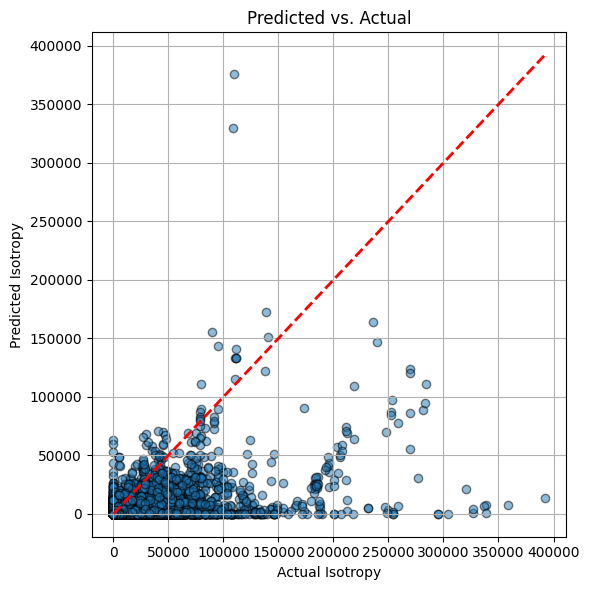

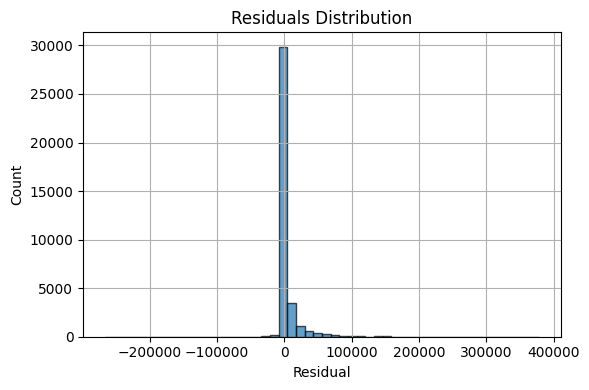

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Load and merge data
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2. Compute geometry features
element_cols = [f'element_{i}' for i in range(1, 26)]
def compute_geometry_features(row):
    nodes = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append((x, y))
    edge_lengths = []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(nodes):
                x1, y1 = nodes[u]; x2, y2 = nodes[v]
                edge_lengths.append(np.hypot(x1-x2, y1-y2))
    return pd.Series({
        'num_nodes': len(nodes),
        'num_edges': len(edge_lengths),
        'avg_edge_length': np.mean(edge_lengths) if edge_lengths else 0.0,
        'std_edge_length': np.std(edge_lengths)  if edge_lengths else 0.0
    })
geom_df = df.apply(compute_geometry_features, axis=1)
df = pd.concat([df, geom_df], axis=1)

# 3. Compute graph-theoretic features
def compute_graph_features(row):
    coords = []
    for i in range(1, 6):
        x, y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            coords.append((x, y))
    G = nx.Graph()
    G.add_nodes_from(range(len(coords)))
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k,5)
            if u < v < len(coords):
                G.add_edge(u, v)
    degs = [d for _, d in G.degree()]
    return pd.Series({
        'avg_degree': np.mean(degs) if degs else 0.0,
        'max_degree': np.max(degs) if degs else 0.0,
        'num_components': nx.number_connected_components(G),
        'avg_clustering': nx.average_clustering(G) if len(G)>0 else 0.0
    })
graph_df = df.apply(compute_graph_features, axis=1)
df = pd.concat([df, graph_df], axis=1)

# 4. Prepare inputs and target
input_cols = (
    element_cols +
    ['num_nodes','num_edges','avg_edge_length','std_edge_length'] +
    ['avg_degree','max_degree','num_components','avg_clustering']
)
df = df.dropna(subset=input_cols + ['Isotropy']).copy()
df['log_iso'] = np.log1p(df['Isotropy'])

X = df[input_cols].values
y = df['log_iso'].values.reshape(-1,1)

# 5. Train/Val/Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# 6. Scale features and targets
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)
y_train_s = scaler_y.transform(y_train)
y_val_s   = scaler_y.transform(y_val)
y_test_s  = scaler_y.transform(y_test)

# 7. Create DataLoaders
train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                         torch.tensor(y_train_s, dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val_s,   dtype=torch.float32),
                         torch.tensor(y_val_s,   dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 8. Define Improved MLP
class ImprovedMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim,256), nn.BatchNorm1d(256), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(256,128), nn.BatchNorm1d(128), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(128,64),  nn.BatchNorm1d(64),  nn.LeakyReLU(), nn.Dropout(0.2),
            nn.Linear(64,32),   nn.BatchNorm1d(32),  nn.LeakyReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x): return self.net(x)

# 9. Train with HuberLoss, AdamW, scheduler, early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(X_train_s.shape[1]).to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                factor=0.5, patience=10)

best_val = float('inf'); patience=20; counter=0
for epoch in range(1,201):
    model.train()
    train_loss=0
    for xb,yb in train_loader:
        xb,yb=xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss=criterion(model(xb), yb)
        loss.backward(); optimizer.step()
        train_loss+=loss.item()*xb.size(0)
    train_loss/=len(train_loader.dataset)

    model.eval(); val_loss=0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb=xb.to(device), yb.to(device)
            val_loss+=criterion(model(xb), yb).item()*xb.size(0)
    val_loss/=len(val_loader.dataset)
    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

    if val_loss<best_val:
        best_val=val_loss; torch.save(model.state_dict(),'best.pth'); counter=0
    else:
        counter+=1
        if counter>=patience:
            print("Early stopping."); break

# 10. Load best model & evaluate
model.load_state_dict(torch.load('best.pth', map_location=device))
model.eval()
with torch.no_grad():
    Xt=torch.tensor(X_test_s, dtype=torch.float32).to(device)
    yp_s=model(Xt).cpu().numpy()
yp_log=scaler_y.inverse_transform(yp_s).flatten()
yt_log=y_test.flatten()
yp=np.expm1(yp_log); yt=np.expm1(yt_log)

mae=r2_score(yt,yp); r2=r2_score(yt,yp)
print(f"\nTest MAE: {mae:.2f}, R²: {r2:.4f}")

# 11. Visualization
plt.figure(figsize=(6,6))
plt.scatter(yt,yp,alpha=0.5,edgecolors='k')
plt.plot([yt.min(),yt.max()],[yt.min(),yt.max()],'r--',lw=2)
plt.xlabel('Actual Isotropy'); plt.ylabel('Predicted Isotropy')
plt.title('Predicted vs. Actual'); plt.grid(); plt.tight_layout(); plt.show()

res=yt-yp
plt.figure(figsize=(6,4))
plt.hist(res,bins=50,edgecolor='k',alpha=0.7)
plt.xlabel('Residual'); plt.ylabel('Count')
plt.title('Residuals Distribution'); plt.grid(); plt.tight_layout(); plt.show()


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([11])) that is differ

Epoch 001 | Val MSE 13.0757
Epoch 002 | Val MSE 12.6818
Epoch 003 | Val MSE 12.6086
Epoch 004 | Val MSE 12.5878
Epoch 005 | Val MSE 12.6187
Epoch 006 | Val MSE 12.5901
Epoch 007 | Val MSE 12.6329
Epoch 008 | Val MSE 12.5941
Epoch 009 | Val MSE 12.5870
Epoch 010 | Val MSE 12.5870
Epoch 011 | Val MSE 12.5872
Epoch 012 | Val MSE 12.5930
Epoch 013 | Val MSE 12.5970
Epoch 014 | Val MSE 12.5881
Epoch 015 | Val MSE 12.5872
Epoch 016 | Val MSE 12.6617
Epoch 017 | Val MSE 12.5874
Epoch 018 | Val MSE 12.5897
Epoch 019 | Val MSE 12.5932
Epoch 020 | Val MSE 12.5930
Epoch 021 | Val MSE 12.6341
Epoch 022 | Val MSE 12.5929
Epoch 023 | Val MSE 12.5880
Epoch 024 | Val MSE 12.5872
Epoch 025 | Val MSE 12.6366
Epoch 026 | Val MSE 12.5871
Epoch 027 | Val MSE 12.6123
Epoch 028 | Val MSE 12.5890
Epoch 029 | Val MSE 12.5892
Early stopping

Test MAE: 5725.51, R²: -0.0945


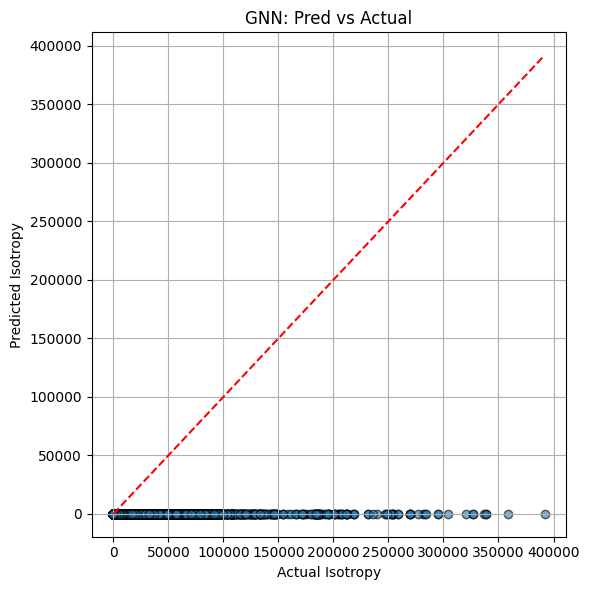

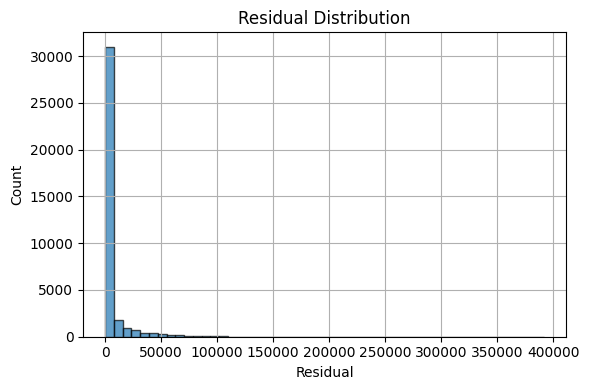

In [ ]:

!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

# 1. Imports
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Load raw CSVs and merge
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 3. Filter out malformed rows
# ensure at least 2 nodes
def has_valid_nodes(row):
    cnt=0
    for i in range(1,6):
        if not np.isnan(row[f'node{i}_x']) and not np.isnan(row[f'node{i}_y']):
            cnt+=1
    return cnt>=2

df = df[df.apply(has_valid_nodes,axis=1)].reset_index(drop=True)

# 4. Prepare graph dataset
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    # extract node coordinates
    nodes = []
    for i in range(1,6):
        x,y = row[f'node{i}_x'], row[f'node{i}_y']
        if not np.isnan(x) and not np.isnan(y):
            nodes.append([x,y])
    x = torch.tensor(nodes, dtype=torch.float)  # [num_nodes,2]

    # build undirected edge_index
    edge_index = []
    for k,col in enumerate(element_cols):
        if row[col]==1:
            u,v = divmod(k,5)
            if u< v < len(nodes):
                edge_index.append([u,v]); edge_index.append([v,u])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # target
    y = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)

    data_list.append(Data(x=x, edge_index=edge_index, y=y))

# 5. Split train/val/test
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val      = train_test_split(train_val, test_size=0.2, random_state=42)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)

# 6. Define GCN model
class GCNReg(torch.nn.Module):
    def __init__(self, in_channels, hidden=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin1  = torch.nn.Linear(hidden, hidden//2)
        self.lin2  = torch.nn.Linear(hidden//2, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)          # [batch_size, hidden]
        x = F.relu(self.lin1(x))
        return self.lin2(x)                     # [batch_size,1]

# 7. Train GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNReg(in_channels=2, hidden=128).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit  = torch.nn.MSELoss()

best_val = float('inf')
patience,counter = 20,0

for epoch in range(1,201):
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = crit(pred, batch.y)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_loss += crit(model(batch), batch.y).item()*batch.num_graphs
    val_loss /= len(val)
    print(f"Epoch {epoch:03d} | Val MSE {val_loss:.4f}")
    if val_loss<best_val:
        best_val=val_loss; torch.save(model.state_dict(),'best_gnn.pth'); counter=0
    else:
        counter+=1
        if counter>=patience:
            print("Early stopping")
            break

# 8. Evaluate on test set
model.load_state_dict(torch.load('best_gnn.pth', map_location=device))
model.eval()
y_pred=[]; y_true=[]
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch).cpu().numpy().flatten()
        y_pred.extend(np.expm1(out))
        y_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nTest MAE: {mae:.2f}, R²: {r2:.4f}")

# 9. Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_true),max(y_true)],[min(y_true),max(y_true)],'r--')
plt.xlabel('Actual Isotropy'); plt.ylabel('Predicted Isotropy')
plt.title('GNN: Pred vs Actual'); plt.grid(True); plt.tight_layout(); plt.show()

res = np.array(y_true)-np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual'); plt.ylabel('Count')
plt.title('Residual Distribution'); plt.grid(True); plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([11])) that is differ

Epoch 001 | Val MSE: 12.6147
Epoch 002 | Val MSE: 12.6485
Epoch 003 | Val MSE: 12.6235
Epoch 004 | Val MSE: 12.6765
Epoch 005 | Val MSE: 12.6922
Epoch 006 | Val MSE: 12.6233
Epoch 007 | Val MSE: 12.6496
Epoch 008 | Val MSE: 12.5909
Epoch 009 | Val MSE: 12.5898
Epoch 010 | Val MSE: 12.5904
Epoch 011 | Val MSE: 12.5884
Epoch 012 | Val MSE: 12.5912
Epoch 013 | Val MSE: 12.5975
Epoch 014 | Val MSE: 12.5926
Epoch 015 | Val MSE: 12.5876
Epoch 016 | Val MSE: 12.5957
Epoch 017 | Val MSE: 12.5914
Epoch 018 | Val MSE: 12.6324
Epoch 019 | Val MSE: 12.6385
Epoch 020 | Val MSE: 12.5953
Epoch 021 | Val MSE: 12.5920
Epoch 022 | Val MSE: 12.6006
Epoch 023 | Val MSE: 12.6014
Epoch 024 | Val MSE: 12.5884
Epoch 025 | Val MSE: 12.5970
Epoch 026 | Val MSE: 12.5931
Epoch 027 | Val MSE: 12.5873
Epoch 028 | Val MSE: 12.5912
Epoch 029 | Val MSE: 12.5902
Epoch 030 | Val MSE: 12.5982
Epoch 031 | Val MSE: 12.6235
Epoch 032 | Val MSE: 12.5950
Epoch 033 | Val MSE: 12.5876
Epoch 034 | Val MSE: 12.5883
Epoch 035 | Va

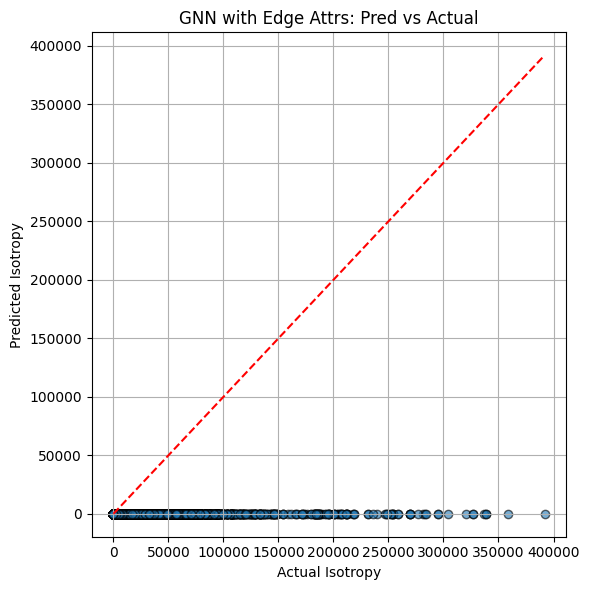

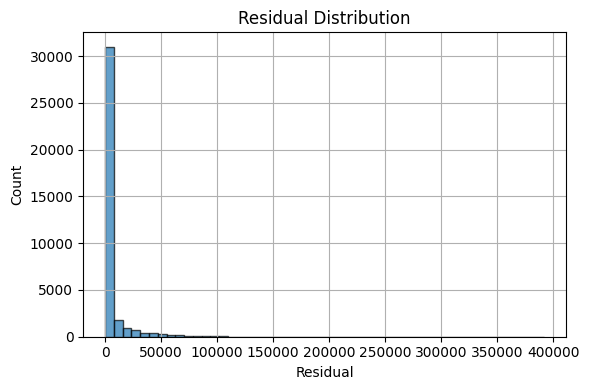

In [ ]:
# 0. Install dependencies in a Colab shell cell:
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

# 1. Imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Load & merge
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 3. Build graph dataset with edge_attr = rod length
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    # nodes
    coords = [(row[f'node{i}_x'], row[f'node{i}_y'])
              for i in range(1,6)
              if not np.isnan(row[f'node{i}_x'])]
    if len(coords)<2: continue
    x = torch.tensor(coords, dtype=torch.float)  # [N,2]

    # edges + compute lengths
    edge_index = []
    edge_attr  = []
    for k,col in enumerate(element_cols):
        if row[col]==1:
            u,v = divmod(k,5)
            if u< v < len(coords):
                edge_index += [[u,v],[v,u]]
                p,q = coords[u], coords[v]
                dist = np.hypot(p[0]-q[0], p[1]-q[1])
                # same attr for both directions
                edge_attr += [dist, dist]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(edge_attr, dtype=torch.float)  # [2E]

    # target
    y = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)

    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

# 4. Split
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val       = train_test_split(train_val, test_size=0.2, random_state=42)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)

# 5. Define improved GNN
class GNNEdgeModel(torch.nn.Module):
    def __init__(self, in_channels, hidden=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin1  = torch.nn.Linear(2*hidden, hidden//2)
        self.lin2  = torch.nn.Linear(hidden//2, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # convert lengths to weights
        edge_weight = 1.0 / (edge_attr + 1e-6)
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        # global pooling: mean + max
        x_mean = global_mean_pool(x, batch)
        x_max  = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        x = F.relu(self.lin1(x))
        return self.lin2(x)

# 6. Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNEdgeModel(in_channels=2, hidden=128).to(device)
opt   = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit  = torch.nn.MSELoss()

best_val = float('inf'); patience=20; counter=0
for epoch in range(1,201):
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        opt.zero_grad()
        loss = crit(model(batch), batch.y)
        loss.backward()
        opt.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_loss += crit(model(batch), batch.y).item() * batch.num_graphs
    val_loss /= len(val)
    print(f"Epoch {epoch:03d} | Val MSE: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_gnn_edge.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# 7. Test & visualize
model.load_state_dict(torch.load('best_gnn_edge.pth', map_location=device))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch).cpu().numpy().flatten()
        y_pred.extend(np.expm1(out))
        y_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nTest MAE: {mae:.2f}, R²: {r2:.4f}")

# 8. Plots
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_true),max(y_true)],[min(y_true),max(y_true)],'r--')
plt.xlabel('Actual Isotropy'); plt.ylabel('Predicted Isotropy')
plt.title('GNN with Edge Attrs: Pred vs Actual'); plt.grid(True); plt.tight_layout(); plt.show()

res = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual'); plt.ylabel('Count')
plt.title('Residual Distribution'); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
# Load & merge CSVs
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# Build list of Data objects
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    # node coords
    coords = [(row[f'node{i}_x'], row[f'node{i}_y']) for i in range(1,6)
              if not np.isnan(row[f'node{i}_x'])]
    if len(coords)<2: continue
    x = torch.tensor(coords, dtype=torch.float)  # [num_nodes,2]
    # edges + edge_attr = rod length
    edge_index, edge_attr = [], []
    for k, col in enumerate(element_cols):
        if row[col]==1:
            u,v = divmod(k,5)
            if u< v < len(coords):
                edge_index += [[u,v],[v,u]]
                p,q = coords[u], coords[v]
                dist = np.hypot(p[0]-q[0], p[1]-q[1])
                edge_attr += [dist, dist]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # [2E,2]
    edge_attr  = torch.tensor(edge_attr, dtype=torch.float).view(-1,1)      # [2E,1]
    # target: log1p(Isotropy)
    y = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)
    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))



In [ ]:
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val      = train_test_split(train_val, test_size=0.2, random_state=42)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)



/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_weighted_gnn.pth', map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch).view(-1).cpu().numpy()
        y_pred.extend(np.expm1(out))
        y_true.extend(np.expm1(batch.y.view(-1).cpu().numpy()))

# Metrics
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nWeighted GNN MAE: {mae:.2f}, R²: {r2:.4f}")

# Pred vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
mn, mx = min(y_true), max(y_true)
plt.plot([mn,mx],[mn,mx],'r--', linewidth=2)
plt.xlabel('Actual Isotropy'); plt.ylabel('Predicted Isotropy')
plt.title('Weighted GNN: Pred vs Actual')
plt.grid(True); plt.tight_layout(); plt.show()

# Residuals
res = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual'); plt.ylabel('Count')
plt.title('Residual Distribution')
plt.grid(True); plt.tight_layout(); plt.show()


In [39]:
# Colab shell cell
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

[CLS] Epoch 01 | Loss: 0.3653
[CLS] Epoch 02 | Loss: 0.3379
[CLS] Epoch 03 | Loss: 0.3239
[CLS] Epoch 04 | Loss: 0.3097
[CLS] Epoch 05 | Loss: 0.2990
[CLS] Epoch 06 | Loss: 0.2892
[CLS] Epoch 07 | Loss: 0.2794
[CLS] Epoch 08 | Loss: 0.2697
[CLS] Epoch 09 | Loss: 0.2632
[CLS] Epoch 10 | Loss: 0.2555
[CLS] Epoch 11 | Loss: 0.2507
[CLS] Epoch 12 | Loss: 0.2426
[CLS] Epoch 13 | Loss: 0.2382
[CLS] Epoch 14 | Loss: 0.2333
[CLS] Epoch 15 | Loss: 0.2286
[CLS] Epoch 16 | Loss: 0.2255
[CLS] Epoch 17 | Loss: 0.2208
[CLS] Epoch 18 | Loss: 0.2169
[CLS] Epoch 19 | Loss: 0.2149
[CLS] Epoch 20 | Loss: 0.2124
[CLS] Epoch 21 | Loss: 0.2080
[CLS] Epoch 22 | Loss: 0.2080
[CLS] Epoch 23 | Loss: 0.2040
[CLS] Epoch 24 | Loss: 0.2016
[CLS] Epoch 25 | Loss: 0.1977
[CLS] Epoch 26 | Loss: 0.1958
[CLS] Epoch 27 | Loss: 0.1940
[CLS] Epoch 28 | Loss: 0.1922
[CLS] Epoch 29 | Loss: 0.1905
[CLS] Epoch 30 | Loss: 0.1895
[CLS] Epoch 31 | Loss: 0.1866
[CLS] Epoch 32 | Loss: 0.1857
[CLS] Epoch 33 | Loss: 0.1838
[CLS] Epoc

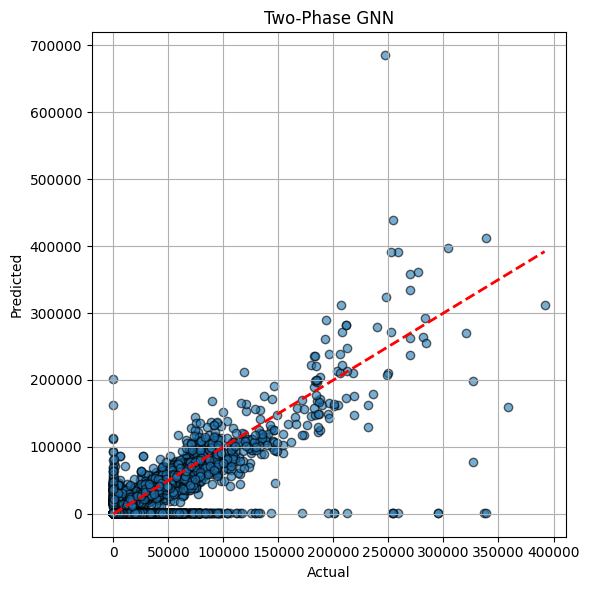

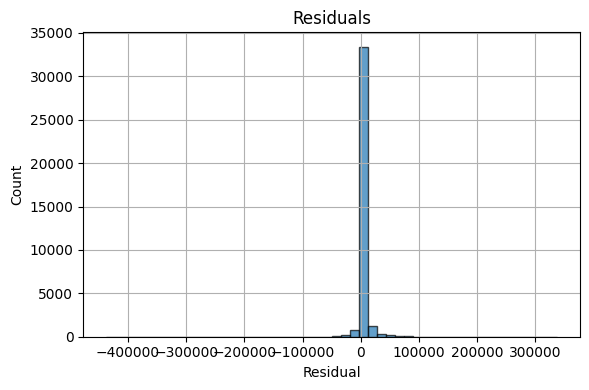

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Load and merge CSVs
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2) Build list of Graph Data objects
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    coords = [(row[f'node{i}_x'], row[f'node{i}_y']) for i in range(1,6)
              if not np.isnan(row[f'node{i}_x'])]
    if len(coords) < 2:
        continue

    x = torch.tensor(coords, dtype=torch.float)                        # (n_nodes, 2)

    edges, lens = [], []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(coords):
                edges += [[u, v], [v, u]]
                p, q = coords[u], coords[v]
                d = np.hypot(p[0] - q[0], p[1] - q[1])
                lens += [d, d]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() # (2, n_edges)
    edge_attr  = torch.tensor(lens, dtype=torch.float).view(-1,1)       # (n_edges, 1)
    y_log = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)

    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_log))

# 3) Split into train / val / test
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val      = train_test_split(train_val, test_size=0.2, random_state=42)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)

# 4) Encoder: node embedding + 2-layer GINEConv + global pooling
class Encoder(torch.nn.Module):
    def __init__(self, in_dim=2, hidden_dim=64):
        super().__init__()
        self.node_emb = torch.nn.Linear(in_dim, hidden_dim)

        mlp1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv1 = GINEConv(mlp1, edge_dim=1)

        mlp2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv2 = GINEConv(mlp2, edge_dim=1)

    def forward(self, data):
        h = F.relu(self.node_emb(data.x))
        h = F.relu(self.conv1(h, data.edge_index, data.edge_attr))
        h = F.relu(self.conv2(h, data.edge_index, data.edge_attr))
        m1 = global_mean_pool(h, data.batch)
        m2 = global_max_pool(h, data.batch)
        return torch.cat([m1, m2], dim=1)   # [batch_size, 2*hidden_dim]

# 5) Classifier: 2*hidden_dim -> 2
class Classifier(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Linear(2*hidden_dim, 2)

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 6) Regressor: 2*hidden_dim -> hidden_dim -> 1
class Regressor(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 7) Instantiate models, optimizers, losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = Classifier(hidden_dim=64).to(device)
reg = Regressor(hidden_dim=64).to(device)

opt_c = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)
opt_r = optim.AdamW(reg.parameters(), lr=1e-3, weight_decay=1e-4)
crit_c = torch.nn.CrossEntropyLoss()
crit_r = torch.nn.MSELoss()

# 8) First stage: classification training
threshold = np.log1p(10000)
for epoch in range(1, 51):
    clf.train()
    total_loss, total_graphs = 0.0, 0
    for batch in train_loader:
        batch = batch.to(device)
        labels = (batch.y.view(-1) > threshold).long()
        out = clf(batch)
        loss = crit_c(out, labels)
        opt_c.zero_grad()
        loss.backward()
        opt_c.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    print(f"[CLS] Epoch {epoch:02d} | Loss: {total_loss/total_graphs:.4f}")

# 9) Second stage: regression on high-value subset
high = [d for d in train if d.y.item() > threshold]
high_loader = DataLoader(high, batch_size=32, shuffle=True)
for epoch in range(1, 201):
    reg.train()
    total_loss, total_graphs = 0.0, 0
    for batch in high_loader:
        batch = batch.to(device)
        preds   = reg(batch).view(-1)
        targets = batch.y.view(-1)
        loss    = crit_r(preds, targets)
        opt_r.zero_grad()
        loss.backward()
        opt_r.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    if epoch % 50 == 0:
        print(f"[REG] Epoch {epoch:03d} | Loss: {total_loss/total_graphs:.4f}")

# 10) Evaluation and visualization
clf.eval(); reg.eval()
low_val = np.expm1(np.log1p(1000))
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        probs = F.softmax(clf(batch), dim=1)[:,1].cpu().numpy()
        mask  = probs > 0.5
        preds = np.full_like(probs, low_val, dtype=float)
        if mask.any():
            out_all = reg(batch).cpu().numpy().flatten()
            preds[mask] = np.expm1(out_all[mask])
        y_pred.extend(preds)
        y_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nTwo-Phase GNN MAE: {mae:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title('Two-Phase GNN'); plt.grid(True); plt.tight_layout(); plt.show()

res = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual'); plt.ylabel('Count')
plt.title('Residuals'); plt.grid(True); plt.tight_layout(); plt.show()


[CLS] Epoch 01 | Loss: 0.3658
[CLS] Epoch 02 | Loss: 0.3351
[CLS] Epoch 03 | Loss: 0.3185
[CLS] Epoch 04 | Loss: 0.3078
[CLS] Epoch 05 | Loss: 0.2973
[CLS] Epoch 06 | Loss: 0.2891
[CLS] Epoch 07 | Loss: 0.2813
[CLS] Epoch 08 | Loss: 0.2728
[CLS] Epoch 09 | Loss: 0.2671
[CLS] Epoch 10 | Loss: 0.2619
[CLS] Epoch 11 | Loss: 0.2554
[CLS] Epoch 12 | Loss: 0.2504
[CLS] Epoch 13 | Loss: 0.2449
[CLS] Epoch 14 | Loss: 0.2416
[CLS] Epoch 15 | Loss: 0.2370
[CLS] Epoch 16 | Loss: 0.2341
[CLS] Epoch 17 | Loss: 0.2300
[CLS] Epoch 18 | Loss: 0.2265
[CLS] Epoch 19 | Loss: 0.2230
[CLS] Epoch 20 | Loss: 0.2200
[CLS] Epoch 21 | Loss: 0.2170
[CLS] Epoch 22 | Loss: 0.2161
[CLS] Epoch 23 | Loss: 0.2126
[CLS] Epoch 24 | Loss: 0.2116
[CLS] Epoch 25 | Loss: 0.2094
[CLS] Epoch 26 | Loss: 0.2078
[CLS] Epoch 27 | Loss: 0.2053
[CLS] Epoch 28 | Loss: 0.2038
[CLS] Epoch 29 | Loss: 0.2010
[CLS] Epoch 30 | Loss: 0.2003
[CLS] Epoch 31 | Loss: 0.1984
[CLS] Epoch 32 | Loss: 0.1961
[CLS] Epoch 33 | Loss: 0.1940
[CLS] Epoc

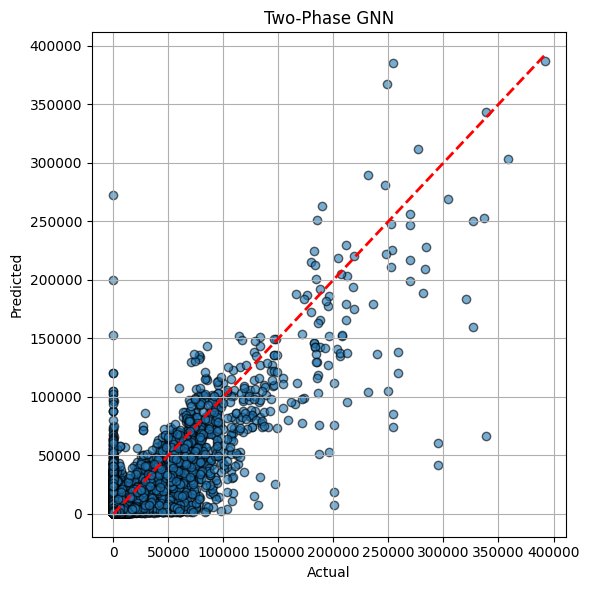

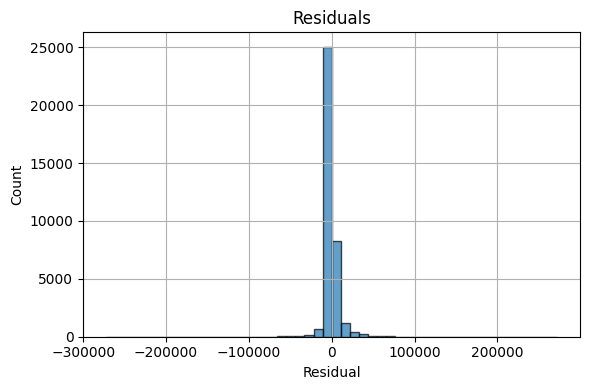

In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Load and merge CSVs
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2) Build list of Graph Data objects
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    coords = [(row[f'node{i}_x'], row[f'node{i}_y']) for i in range(1,6)
              if not np.isnan(row[f'node{i}_x'])]
    if len(coords) < 2:
        continue

    x = torch.tensor(coords, dtype=torch.float)                        # (n_nodes, 2)

    edges, lens = [], []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(coords):
                edges += [[u, v], [v, u]]
                p, q = coords[u], coords[v]
                d = np.hypot(p[0] - q[0], p[1] - q[1])
                lens += [d, d]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() # (2, n_edges)
    edge_attr  = torch.tensor(lens, dtype=torch.float).view(-1,1)       # (n_edges, 1)
    y_log = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)

    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_log))

# 3) Split into train / val / test
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val      = train_test_split(train_val, test_size=0.2, random_state=42)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)

# 4) Encoder: node embedding + 2-layer GINEConv + global pooling
class Encoder(torch.nn.Module):
    def __init__(self, in_dim=2, hidden_dim=64):
        super().__init__()
        self.node_emb = torch.nn.Linear(in_dim, hidden_dim)

        mlp1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv1 = GINEConv(mlp1, edge_dim=1)

        mlp2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv2 = GINEConv(mlp2, edge_dim=1)

    def forward(self, data):
        h = F.relu(self.node_emb(data.x))
        h = F.relu(self.conv1(h, data.edge_index, data.edge_attr))
        h = F.relu(self.conv2(h, data.edge_index, data.edge_attr))
        m1 = global_mean_pool(h, data.batch)
        m2 = global_max_pool(h, data.batch)
        return torch.cat([m1, m2], dim=1)   # [batch_size, 2*hidden_dim]

# 5) Classifier: 2*hidden_dim -> 2
class Classifier(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Linear(2*hidden_dim, 2)

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 6) Regressor: 2*hidden_dim -> hidden_dim -> 1
class Regressor(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 7) Instantiate models, optimizers, losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = Classifier(hidden_dim=64).to(device)
reg = Regressor(hidden_dim=64).to(device)

opt_c = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)
opt_r = optim.AdamW(reg.parameters(), lr=1e-3, weight_decay=1e-4)
crit_c = torch.nn.CrossEntropyLoss()
crit_r = torch.nn.MSELoss()

# 8) First stage: classification training
threshold = np.log1p(10000)
for epoch in range(1, 51):
    clf.train()
    total_loss, total_graphs = 0.0, 0
    for batch in train_loader:
        batch = batch.to(device)
        labels = (batch.y.view(-1) > threshold).long()
        out = clf(batch)
        loss = crit_c(out, labels)
        opt_c.zero_grad()
        loss.backward()
        opt_c.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    print(f"[CLS] Epoch {epoch:02d} | Loss: {total_loss/total_graphs:.4f}")

# 9) Second stage: regression on high-value subset
high = [d for d in train if d.y.item() > threshold]
high_loader = DataLoader(high, batch_size=32, shuffle=True)
for epoch in range(1, 201):
    reg.train()
    total_loss, total_graphs = 0.0, 0
    for batch in high_loader:
        batch = batch.to(device)
        preds   = reg(batch).view(-1)
        targets = batch.y.view(-1)
        loss    = crit_r(preds, targets)
        opt_r.zero_grad()
        loss.backward()
        opt_r.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    if epoch % 50 == 0:
        print(f"[REG] Epoch {epoch:03d} | Loss: {total_loss/total_graphs:.4f}")

# 10) Evaluation with soft-blend & threshold tuning
clf.eval(); reg.eval()

low_val = np.expm1(np.log1p(1000))
probs_val, reg_val, y_val_true = [], [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        p = F.softmax(clf(batch), dim=1)[:,1].cpu().numpy()
        out = reg(batch).cpu().numpy().flatten()
        probs_val.append(p)
        reg_val.append(out)
        y_val_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

probs_val = np.concatenate(probs_val)
reg_val   = np.concatenate(reg_val)
y_val_true = np.array(y_val_true)

best_mae, best_t = float('inf'), 0.0
for t in np.linspace(0.0, 1.0, 51):
    preds = (1-probs_val)*low_val + probs_val * np.expm1(reg_val)
    mae = mean_absolute_error(y_val_true, preds)
    if mae < best_mae:
        best_mae, best_t = mae, t

print(f"Best val MAE={best_mae:.1f} at threshold={best_t:.2f}")

y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p = F.softmax(clf(batch), dim=1)[:,1].cpu().numpy()
        out = reg(batch).cpu().numpy().flatten()
        preds = (1-p)*low_val + p * np.expm1(out)
        y_pred.extend(preds)
        y_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nOptimized Two-Phase GNN MAE: {mae:.2f}, R²: {r2:.4f}")
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Two-Phase GNN')
plt.grid(True)
plt.tight_layout()
plt.show()

res = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


[CLS] Epoch 01 | Loss: 0.3752
[CLS] Epoch 02 | Loss: 0.3362
[CLS] Epoch 03 | Loss: 0.3219
[CLS] Epoch 04 | Loss: 0.3130
[CLS] Epoch 05 | Loss: 0.3043
[CLS] Epoch 06 | Loss: 0.2951
[CLS] Epoch 07 | Loss: 0.2871
[CLS] Epoch 08 | Loss: 0.2781
[CLS] Epoch 09 | Loss: 0.2719
[CLS] Epoch 10 | Loss: 0.2633
[CLS] Epoch 11 | Loss: 0.2564
[CLS] Epoch 12 | Loss: 0.2503
[CLS] Epoch 13 | Loss: 0.2453
[CLS] Epoch 14 | Loss: 0.2397
[CLS] Epoch 15 | Loss: 0.2347
[CLS] Epoch 16 | Loss: 0.2307
[CLS] Epoch 17 | Loss: 0.2255
[CLS] Epoch 18 | Loss: 0.2210
[CLS] Epoch 19 | Loss: 0.2172
[CLS] Epoch 20 | Loss: 0.2157
[CLS] Epoch 21 | Loss: 0.2109
[CLS] Epoch 22 | Loss: 0.2095
[CLS] Epoch 23 | Loss: 0.2069
[CLS] Epoch 24 | Loss: 0.2056
[CLS] Epoch 25 | Loss: 0.2025
[CLS] Epoch 26 | Loss: 0.2006
[CLS] Epoch 27 | Loss: 0.1989
[CLS] Epoch 28 | Loss: 0.1972
[CLS] Epoch 29 | Loss: 0.1949
[CLS] Epoch 30 | Loss: 0.1934
[CLS] Epoch 31 | Loss: 0.1924
[CLS] Epoch 32 | Loss: 0.1905
[CLS] Epoch 33 | Loss: 0.1892
[CLS] Epoc

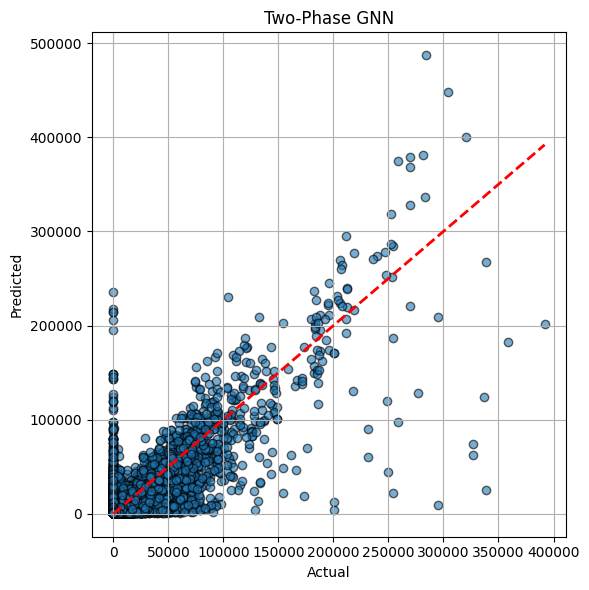

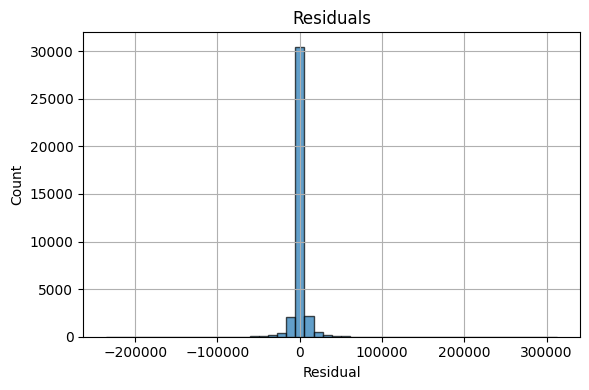

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Load and merge CSVs
feat_df = pd.read_csv('/content/cm-features.csv')
prop_df = pd.read_csv('/content/cm-mechanical property.csv')
df = pd.merge(feat_df, prop_df, on='name')

# 2) Build list of Graph Data objects
element_cols = [f'element_{i}' for i in range(1,26)]
data_list = []
for _, row in df.iterrows():
    coords = [(row[f'node{i}_x'], row[f'node{i}_y']) for i in range(1,6)
              if not np.isnan(row[f'node{i}_x'])]
    if len(coords) < 2:
        continue

    x = torch.tensor(coords, dtype=torch.float)                        # (n_nodes, 2)

    edges, lens = [], []
    for k, col in enumerate(element_cols):
        if row[col] == 1:
            u, v = divmod(k, 5)
            if u < v < len(coords):
                edges += [[u, v], [v, u]]
                p, q = coords[u], coords[v]
                d = np.hypot(p[0] - q[0], p[1] - q[1])
                lens += [d, d]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() # (2, n_edges)
    edge_attr  = torch.tensor(lens, dtype=torch.float).view(-1,1)       # (n_edges, 1)
    y_log = torch.tensor([np.log1p(row['Isotropy'])], dtype=torch.float)

    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_log))

# 3) Split into train / val / test
train_val, test = train_test_split(data_list, test_size=0.2, random_state=42)
train, val      = train_test_split(train_val, test_size=0.2, random_state=42)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32)
test_loader  = DataLoader(test,  batch_size=32)

# 4) Encoder: node embedding + 2-layer GINEConv + global pooling
class Encoder(torch.nn.Module):
    def __init__(self, in_dim=2, hidden_dim=64):
        super().__init__()
        self.node_emb = torch.nn.Linear(in_dim, hidden_dim)

        mlp1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv1 = GINEConv(mlp1, edge_dim=1)

        mlp2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv2 = GINEConv(mlp2, edge_dim=1)

    def forward(self, data):
        h = F.relu(self.node_emb(data.x))
        h = F.relu(self.conv1(h, data.edge_index, data.edge_attr))
        h = F.relu(self.conv2(h, data.edge_index, data.edge_attr))
        m1 = global_mean_pool(h, data.batch)
        m2 = global_max_pool(h, data.batch)
        return torch.cat([m1, m2], dim=1)   # [batch_size, 2*hidden_dim]

# 5) Classifier: 2*hidden_dim -> 2
class Classifier(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Linear(2*hidden_dim, 2)

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 6) Regressor: 2*hidden_dim -> hidden_dim -> 1
class Regressor(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = Encoder(in_dim=2, hidden_dim=hidden_dim)
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        h = self.enc(data)
        return self.lin(h)

# 7) Instantiate models, optimizers, losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = Classifier(hidden_dim=64).to(device)
reg = Regressor(hidden_dim=64).to(device)

opt_c = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)
opt_r = optim.AdamW(reg.parameters(), lr=1e-3, weight_decay=1e-4)
crit_c = torch.nn.CrossEntropyLoss()
crit_r = torch.nn.MSELoss()

# 8) First stage: classification training
threshold = np.log1p(10000)
for epoch in range(1, 51):
    clf.train()
    total_loss, total_graphs = 0.0, 0
    for batch in train_loader:
        batch = batch.to(device)
        labels = (batch.y.view(-1) > threshold).long()
        out = clf(batch)
        loss = crit_c(out, labels)
        opt_c.zero_grad()
        loss.backward()
        opt_c.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    print(f"[CLS] Epoch {epoch:02d} | Loss: {total_loss/total_graphs:.4f}")

# 9) Second stage: regression on high-value subset
high = [d for d in train if d.y.item() > threshold]
high_loader = DataLoader(high, batch_size=32, shuffle=True)
for epoch in range(1, 201):
    reg.train()
    total_loss, total_graphs = 0.0, 0
    for batch in high_loader:
        batch = batch.to(device)
        preds   = reg(batch).view(-1)
        targets = batch.y.view(-1)
        loss    = crit_r(preds, targets)
        opt_r.zero_grad()
        loss.backward()
        opt_r.step()
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    if epoch % 50 == 0:
        print(f"[REG] Epoch {epoch:03d} | Loss: {total_loss/total_graphs:.4f}")

# 10) Evaluation with soft-blend & threshold tuning
clf.eval(); reg.eval()

low_val = np.expm1(np.log1p(1000))
probs_val, reg_val, y_val_true = [], [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        p = F.softmax(clf(batch), dim=1)[:,1].cpu().numpy()
        out = reg(batch).cpu().numpy().flatten()
        probs_val.append(p)
        reg_val.append(out)
        y_val_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

probs_val = np.concatenate(probs_val)
reg_val   = np.concatenate(reg_val)
y_val_true = np.array(y_val_true)

best_mae, best_t = float('inf'), 0.0
for t in np.linspace(0.0, 1.0, 51):
    preds = (1-probs_val)*low_val + probs_val * np.expm1(reg_val)
    mae = mean_absolute_error(y_val_true, preds)
    if mae < best_mae:
        best_mae, best_t = mae, t

print(f"Best val MAE={best_mae:.1f} at threshold={best_t:.2f}")

y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p = F.softmax(clf(batch), dim=1)[:,1].cpu().numpy()
        out = reg(batch).cpu().numpy().flatten()
        preds = (1-p)*low_val + p * np.expm1(out)
        y_pred.extend(preds)
        y_true.extend(np.expm1(batch.y.cpu().numpy().flatten()))

mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nOptimized Two-Phase GNN MAE: {mae:.2f}, R²: {r2:.4f}")
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Two-Phase GNN')
plt.grid(True)
plt.tight_layout()
plt.show()

res = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()
